Возьмем готовый датасет обращений в поддержку банковского мобильного приложения

In [201]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import warnings
import json
import nltk
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
# nltk.download()


In [182]:
messages = []
for line in open('/Users/Svyatoslav/Downloads/хакатон rosatom/noisy-data-master/corpora/fin_apps_testing_labeled.json', 
                 'r'):
    messages.append(json.loads(line))

уже сделана лемматизация (приведены окончания), убраны стоп слова, смотри stemmedText

In [186]:
data=pd.DataFrame(messages)
data['problemscore01']=data['problemscore'].apply(lambda x: 1 if x == 'problem' else 0)
data.head()

,text,stemmedText,problemscore,problemscore01
0,"Сделали бы еще , что бы код из смски сам вста...","сделать бы еще , что бы код из смска сам встав...",noproblem,0
1,Хорошее приложение работать удобно и быстро н...,хороший приложение работать удобно и быстро ни...,noproblem,0
2,Но всё же сделайте для планшетов горизонтальн...,но все же сделать для планшет горизонтальный п...,problem,1
3,"Супер, оплаты в одно касание, глюков не видел...","супер; оплата в один касание; глюк не видеть, ...",noproblem,0
4,Не возможно проверить баланс! Зависает телефо...,не возможно проверять баланс; зависать телефон...,problem,1


# Clustering text documents using k-means


Word Count Median: 13.0
count    2869.000000
mean       13.114674
std         2.367056
min         5.000000
25%        11.000000
50%        13.000000
75%        15.000000
max        23.000000
Name: word_count, dtype: float64


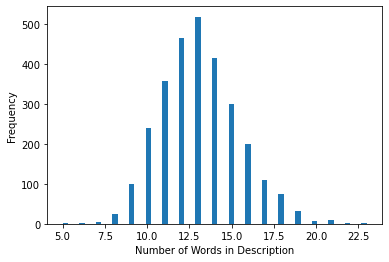

In [187]:
#add a column for the word count
data['word_count'] = data['stemmedText'].apply(lambda x: len(str(x).split(" ")))
print("Word Count Median: " + str(data['word_count'].median()))
print(data['word_count'].describe())
x = data['word_count']
n_bins = 55
plt.hist(x, bins=n_bins)
plt.xlabel('Number of Words in Description')
plt.ylabel('Frequency')
plt.show()

# Векторизация текста через TF-IDF 
(term frequency-inverse document frequency)


In [188]:
# download stopwords from NLTK 
stopWords = set(stopwords.words('russian'))
stopWords = list(stopWords)
stopWords.remove('не')
stopWords = set(stopWords)
print('Number of stop words:', len(stopWords))

Number of stop words: 150


In [190]:
#construct a new list to store the cleaned text
clean_desc = []
for i in range(len(data['stemmedText'])):
    desc = data['stemmedText'][i].lower()
    
    #remove punctuation
#     desc = re.sub('[^a-zA-Z]', ' ', desc)
    
    #remove tags
    desc = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",desc)
    
    #remove special characters and digits
    desc = re.sub("(\\d|\\W)+"," ",desc)
    
    split_text = desc.split()
    
    #Lemmatisation
    lem = WordNetLemmatizer()
    split_text = [lem.lemmatize(word) for word in split_text if not word in stopWords and len(word) >2] 
    split_text = " ".join(split_text)
    clean_desc.append(split_text)
    
data['clean_desc']=clean_desc

In [191]:
#TF-IDF vectorizer
tfv = TfidfVectorizer(stop_words = stopWords, ngram_range = (1,1))
#transform
vec_text = tfv.fit_transform(clean_desc)
#returns a list of words.
words = tfv.get_feature_names()
print(len(clean_desc),len(words))



2869 3390


# Построим кластеризацию через k-means

In [193]:
# общая задача состоит в том, чтобы посмотреть какие есть кластера, и различаются ли они по лейблам "проблема" и "не проблема"

#setup kmeans clustering
kmeans = KMeans(n_clusters = 10, n_init = 17, n_jobs = -1, tol = 0.01, max_iter = 200)
#fit the data 
kmeans.fit(vec_text)
#this loop transforms the numbers back into words
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[i] for i in centroid))

/Users/Svyatoslav/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


0 : карта, перевод, деньги, переводить, возможность, счет, приложение, виртуальный, номер, банк
1 : приложение, работать, обновление, банк, это, сделать, мочь, телефон, счет, деньги
2 : очень, удобный, приложение, удобно, спасибо, хороший, разработчик, работать, нравиться, отличный
3 : штраф, показывать, оплачивать, просрочивать, висеть, назад, год, приложение, гибдд, писать
4 : пароль, вводить, логин, ввод, буква, мочь, цифра, писать, входить, заходить
5 : соединение, плохой, интернет, писать, хотя, проблема, зайти, часто, обновление, невозможно
6 : пользоваться, приложение, удобно, год, очень, спасибо, хороший, давно, банк, отличный
7 : ошибка, смс, приходить, код, выдавать, работать, писать, приложение, исправлять, мочь
8 : добавлять, оплата, возможность, шаблон, интернет, пожалуйста, услуга, платеж, сделать, приложение
9 : версия, старый, новый, вернуть, приложение, оставлять, это, весь, предыдущий, работать


In [195]:
kmeans_indices=kmeans.fit_predict(vec_text)

print(len(kmeans_indices),len(clean_desc),len(words))
pca=PCA(n_components=2)

ar=vec_text.toarray()
scatter_plot_points=pca.fit_transform(ar)
color=['r','g','b','c','m','y','k','w','y','k','w']

print(data['problemscore'].value_counts())



/Users/Svyatoslav/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


2869 2869 3390
problem      1653
noproblem    1216
Name: problemscore, dtype: int64


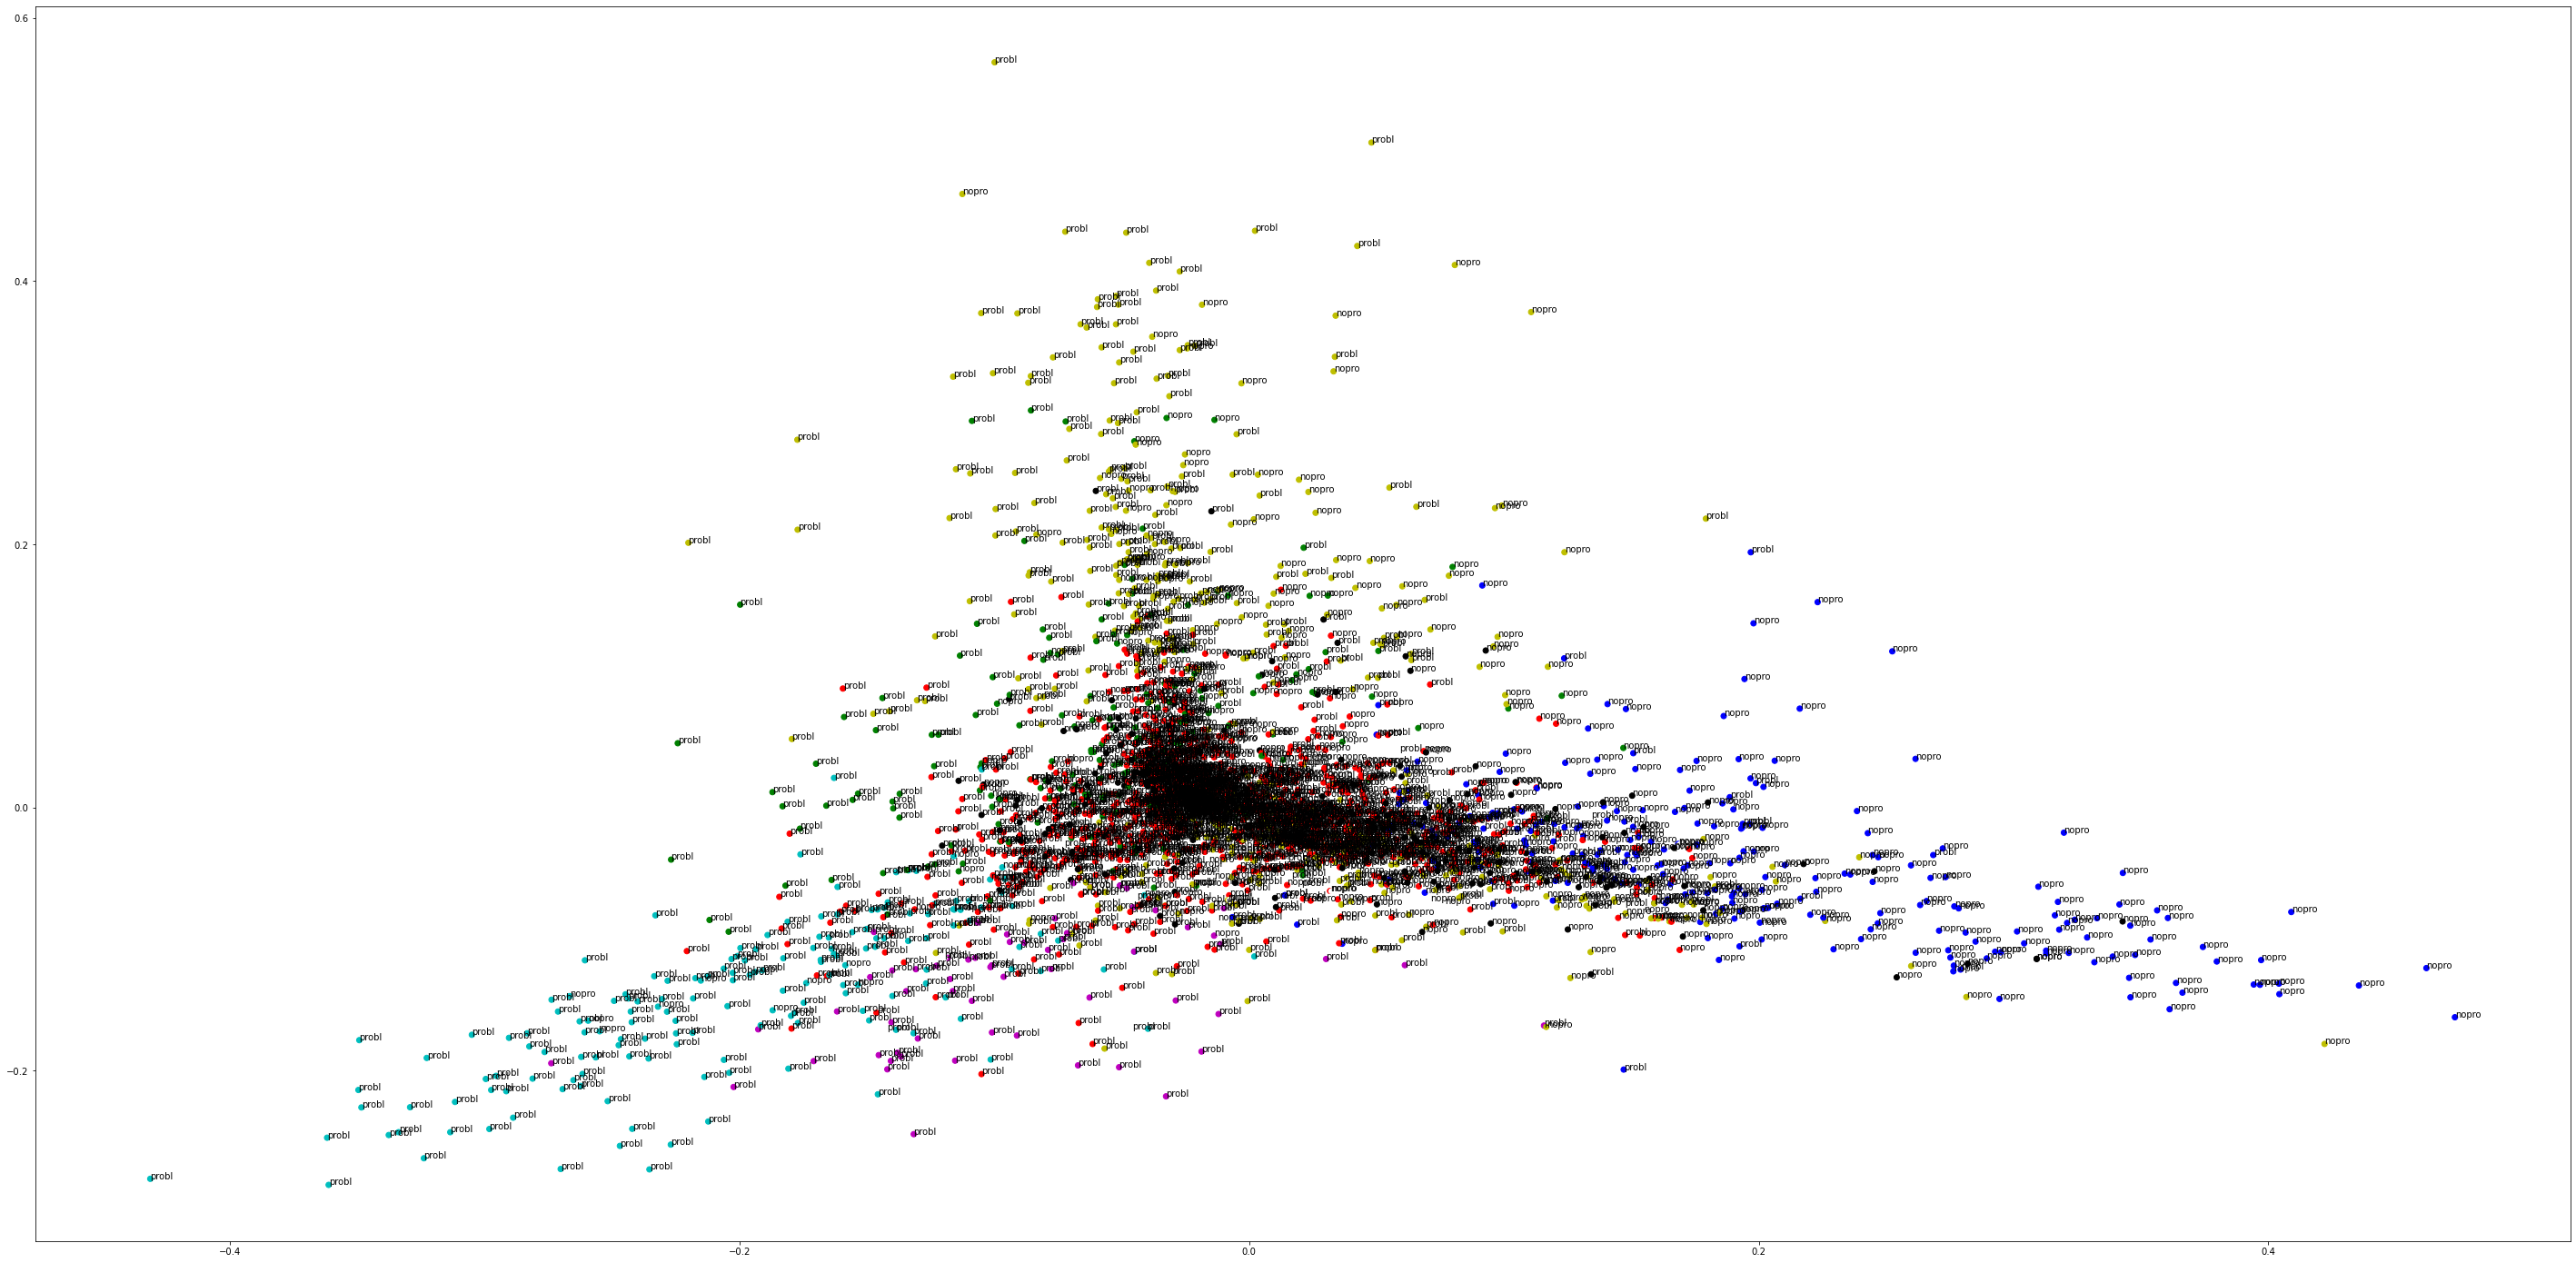

In [196]:
fig, ax=plt.subplots(figsize=(50,25))
x = [j[0] for j in scatter_plot_points]
y = [j[1] for j in scatter_plot_points]

plt.scatter(x,y,c=[color[i] for i in kmeans_indices])

problems=data['problemscore'].values

for i, txt in enumerate(problems):
    ax.annotate(txt[0:5], (x[i],y[i]))

plt.savefig('/Users/Svyatoslav/Downloads/хакатон rosatom/tst.png')

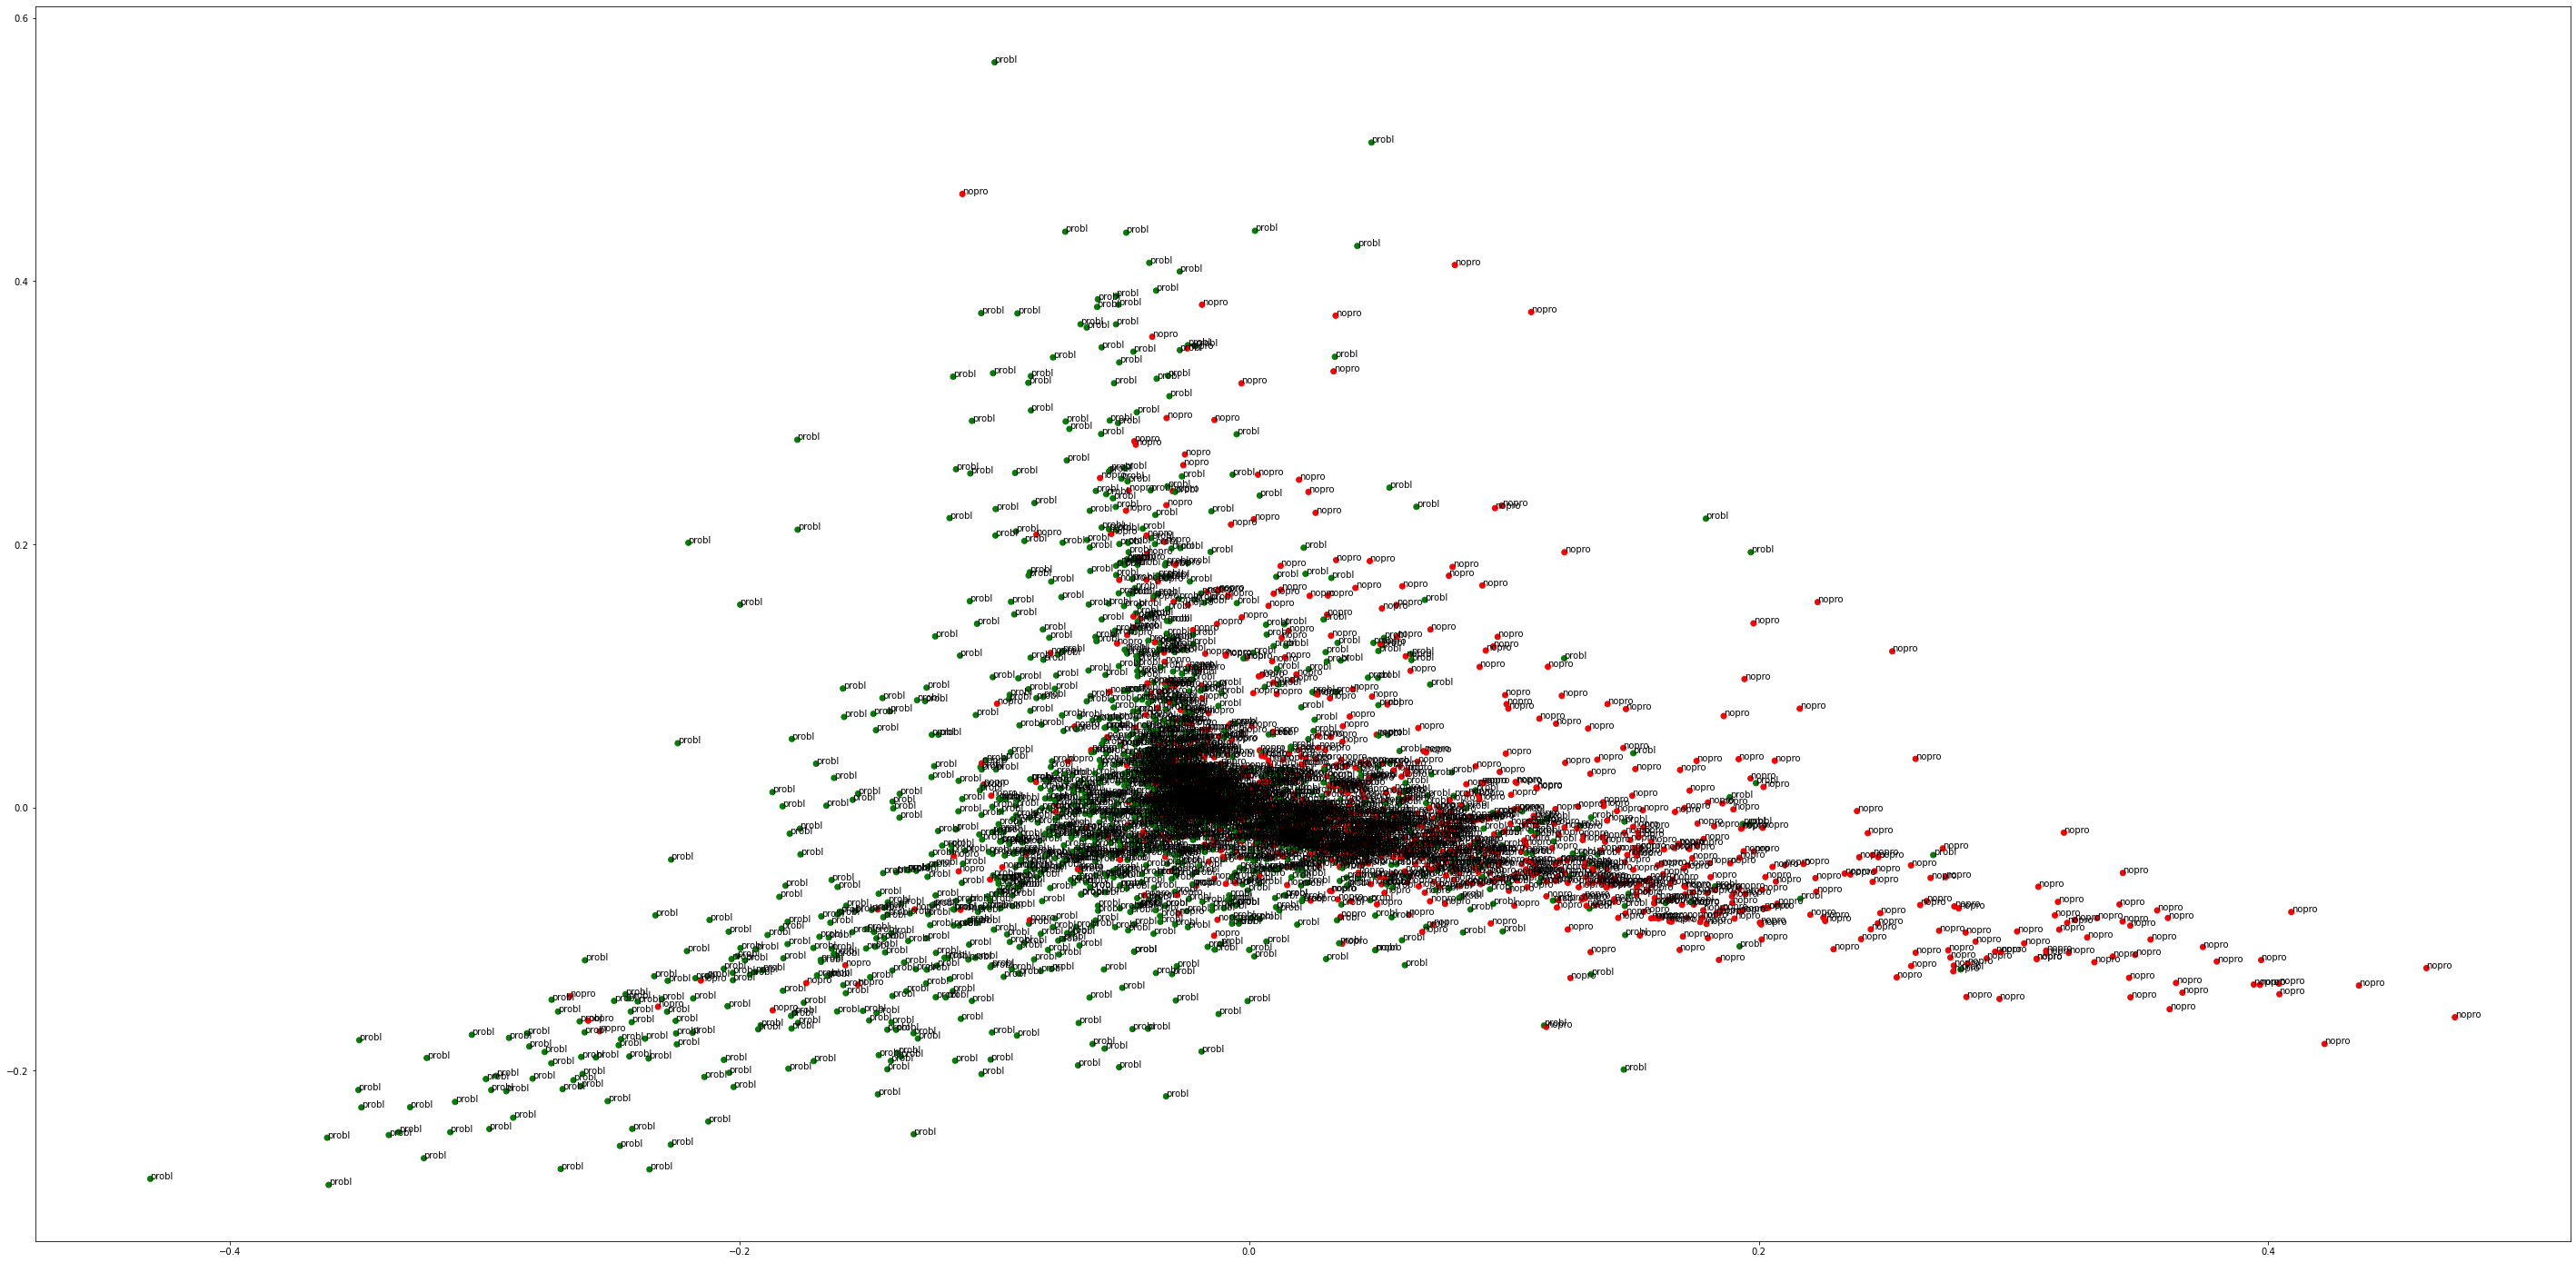

In [198]:
fig, ax=plt.subplots(figsize=(50,25))
x = [j[0] for j in scatter_plot_points]
y = [j[1] for j in scatter_plot_points]

plt.scatter(x,y,c=[color[i] for i in data['problemscore01']])

for i, txt in enumerate(problems):
    ax.annotate(txt[0:5], (x[i],y[i]))

plt.savefig('/Users/Svyatoslav/Downloads/хакатон rosatom/tst2.png')

Визуализировать распределения problem/noproblem и кластеров kmeans